When I give talks about probabilistic programming and Bayesian statistics, I usually gloss over the details of how inference is actually performed, treating it as a black box essentially. The beauty of probabilistic programming is that you actually don't *have* to understand how the inference works in order to build models, but it certainly helps.

在我做概率编程和贝叶斯统计方面的演讲时，我通常不会提及背后的推断细节，而是将其看作一个黑盒子。概率编程的优雅之处在于，构建模型的过程中，你*不必*理解所有的推断细节，当然，了解一些的话显然会有所帮助。

When I presented a new Bayesian model to [Quantopian's](https://quantopian.com) CEO, [Fawce](https://quantopian.com/about), who wasn't trained in Bayesian stats but is eager to understand it, he started to ask about the part I usually gloss over: "Thomas, how does the inference actually work? How do we get these magical samples from the posterior?". 

有一次，我给[Quantopian](https://quantopian.com)的CEO[Fawce](https://quantopian.com/about)演示一个新的贝叶斯模型，Fawce并没有受过贝叶斯统计方面的训练，很好奇地想要理解它，于是问道了我通常略去的那部分：“Thomas，它是怎么进行推断的呢？我们是如何从后验中得到这些神奇的采样的呢？”

Now I could have said: "Well that's easy, MCMC generates samples from the posterior distribution by constructing a reversible Markov-chain that has as its equilibrium distribution the target posterior distribution. Questions?".

我可以回答说：“嗯，很简单，我们可以构建一个可逆的马尔可夫链，其稳态的分布与目标后验分布一致，然后从中进行采样。还有没有问题？”

That statement is correct, but is it useful? My pet peeve with how math and stats are taught is that no one ever tells you about the intuition behind the concepts (which is usually quite simple) but only hands you some scary math. This is certainly the way I was taught and I had to spend countless hours banging my head against the wall until that euraka moment came about. Usually things weren't as scary or seemingly complex once I deciphered what it meant.

上面的描述是正确的，但这么描述有用吗？我最受不了的是数学和统计学的教学方式，从来没有人告诉你那些概念背后的直觉（通常其实很简单），而是直接甩给你一堆数学。我也是这么过来的，为此我曾花费了无数时间抓狂，直到灵光一现。通常，一旦我理解了那些概念，它们看起来似乎也没那么可怕和复杂了。

This blog post is an attempt at trying to explain the *intuition* behind MCMC sampling (specifically, the [Metropolis algorithm](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm)). Critically, we'll be using code examples rather than formulas or math-speak. Eventually you'll need that but I personally think it's better to start with the an example and build the intuition before you move on to the math.

这篇博客尝试解释MCMC采样（尤其是[Metropolis algorithm](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm)）背后的*直觉*。严格地说，我们将使用代码而不是公式或者数学描述，当然你最后还是需要去看看公式的，不过在此之前，我个人认为从一个例子出发构建起直觉更好一些。

## The problem and its unintuitive solution

## 问题和不那么直观的解决方案

Lets take a look at [Bayes formula](https://en.wikipedia.org/wiki/Bayes%27_theorem):

让我们首先看看[贝叶斯公式](https://en.wikipedia.org/wiki/Bayes%27_theorem):

$$P(\theta|x) = \frac{P(x|\theta) P(\theta)}{P(x)}$$

We have $P(\theta|x)$, the probability of our model parameters $\theta$ given the data $x$ and thus our quantity of interest. To compute this we multiply the prior $P(\theta)$ (what we think about $\theta$ before we have seen any data) and the likelihood $P(x|\theta)$, i.e. how we think our data is distributed. This nominator is pretty easy to solve for.

这里$P(\theta|x)$表示我们模型的参数$\theta$在给定数据$x$条件下的概率，也是我们感兴趣的部分，为了计算它，我们将先验$P(\theta)$(在看到任何数据之前我们对$\theta$的理解)和似然$P(x|\theta)$（我们认为数据是怎样分布的）这两个部分相乘。这样等式右边的分子部分很容易就算出来了。

However, lets take a closer look at the denominator. $P(x)$ which is also called the evidence (i.e. the evidence that the data x was generated by this model). We can compute this quantity by integrating over all possible parameter values:

不过，让我们进一步看看分母部分。$P(x)$，也称作证据，我们可以对所有可能的参数求积分之后得到这个变量：

$$P(x) = \int_\Theta P(x, \theta) \, \mathrm{d}\theta$$

This is the key difficulty with Bayes formula -- while the formula looks innocent enough, for even slightly non-trivial models you just can't compute the posterior in a closed-form way. 

这正是贝叶斯公式的难点所在——尽管这个公式看起来很简洁，但即使是对于一些很简单的模型，你也很难得到一个封闭形式的后验。

Now we might say "OK, if we can't solve something, could we try to approximate it? For example, if we could somehow draw samples from that posterior we can [Monte Carlo approximate](https://en.wikipedia.org/wiki/Monte_Carlo_method) it." Unfortunately, to directly sample from that distribution you not only have to solve Bayes formula, but also invert it, so that's even harder. 

此刻你可能说：“OK，虽然我们不能直接求解，那能不能近似求解呢？比如，加入可以从后验中采样，那么我们就可以用[蒙特卡洛近似](https://en.wikipedia.org/wiki/Monte_Carlo_method)来计算”，不幸的是，想要直接从分布中采样，不仅需要求解贝叶斯公式，还需要反过来，也就是说，事情变得更复杂了。

Then we might say "Well, instead let's construct an ergodic, reversible Markov chain that has as an equilibrium distribution which matches our posterior distribution". I'm just kidding, most people wouldn't say that as it sounds bat-shit crazy. If you can't compute it, can't sample from it, then constructing that Markov chain with all these properties must be even harder.

那我们可以说：“呃，那我们就构建一个马尔可夫链，其稳态的分布与我们的后验分布一致”。开个玩笑，呵呵。大多数人不会这么说，这听起来太疯狂了。如果你既不能计算后验，又不能从中采样，那构建一个符合这些条件的马尔可夫链只会更困难。

The surprising insight though is that this is actually very easy and there exist a general class of algorithms that do this called [**Markov chain Monte Carlo**](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) (constructing a Markov chain to do Monte Carlo approximation).

神奇的是，这么做实际上很简单，有一类算法专门用来做这个，即[马尔科夫链-蒙特卡洛](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo)(构建马尔可夫链去做蒙特卡洛近似)。

## Setting up the problem

问题描述

First, lets import our modules.

首先导入一些库

In [5]:
%matplotlib inline

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm

sns.set_style('white')
sns.set_context('talk')

np.random.seed(123)

%config InlineBackend.figure_format = 'retina'

Lets generate some data: 100 points from a normal centered around zero. Our goal will be to estimate the posterior of the mean `mu` (we'll assume that we know the standard deviation to be 1).

先产生一些数据：从均值为0的正态分布中采样100个点。我们的目标是估计均值`mu`的后验（假设我们已经知道了标准差是1）。

In [6]:
data = np.random.randn(20)

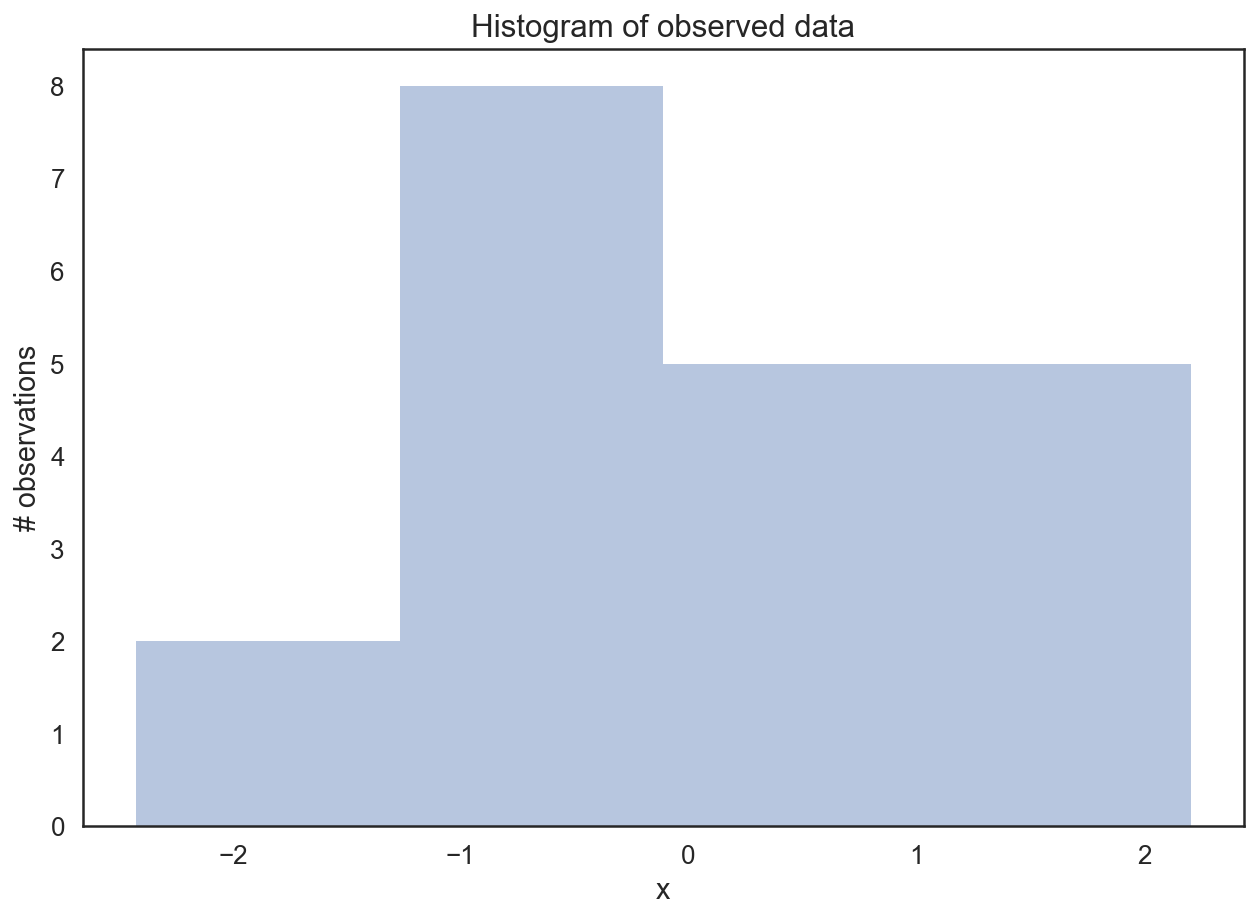

In [7]:
ax = plt.subplot()
sns.distplot(data, kde=False, ax=ax)
_ = ax.set(title='Histogram of observed data', xlabel='x', ylabel='# observations');

Next, we have to define our model. In this simple case, we will assume that this data is normal distributed, i.e. the likelihood of the model is normal. As you know, a normal distribution has two parameters -- mean $\mu$ and standard deviation $\sigma$. For simplicity, we'll assume we know that $\sigma = 1$ and we'll want to infer the posterior for $\mu$. For each parameter we want to infer, we have to chose a prior. For simplicity, lets also assume  a Normal distribution as a prior for $\mu$. Thus, in stats speak our model is:

接下来定义我们的模型。在这个简单的例子中，我们假设数据服从正态分布，即模型的似然服从正态分布。正态分布有两个参数——均值$\mu$和标准差$\sigma$。为了简单起见，我们假设$\sigma=1$，希望推断出$\mu$的后验。对于我们想要推断的每个参数，我们都需要为其选择一个先验。这里我们简单地使用正态分布作为$\mu$的先验，因而，用统计的语言来描述我们的模型便是下面的式子：

$$\mu \sim \text{Normal}(0, 1)\\
x\mid \mu \sim \text{Normal}(x; \mu, 1)$$

What is convenient, is that for this model, we actually can compute the posterior analytically. That's because for a normal likelihood with known standard deviation, the normal prior for `mu` is [**conjugate**](https://en.wikipedia.org/wiki/Conjugate_prior) (conjugate here means that our posterior will follow the same distribution as the prior), so we know that our posterior for $\mu$ is also normal. We can easily look up on wikipedia how we can compute the parameters of the posterior. For a mathemtical derivation of this, see [here](https://docs.google.com/viewer?a=v&pid=sites&srcid=ZGVmYXVsdGRvbWFpbnxiYXllc2VjdHxneDplNGY0MDljNDA5MGYxYTM).

对这个模型而言，我们可以从分析的角度计算出后验。这是因为对于一个已知标准差的正态似然，其正态先验是[共轭的](https://en.wikipedia.org/wiki/Conjugate_prior)（这里共轭的是指后验的分布形式与先验是一样的），既然我们知道了$\mu$的后验是正态分布，那么我们可以马上查维基百科看看怎么计算后验的参数，具体的数学推导可以看[这里](https://docs.google.com/viewer?a=v&pid=sites&srcid=ZGVmYXVsdGRvbWFpbnxiYXllc2VjdHxneDplNGY0MDljNDA5MGYxYTM)

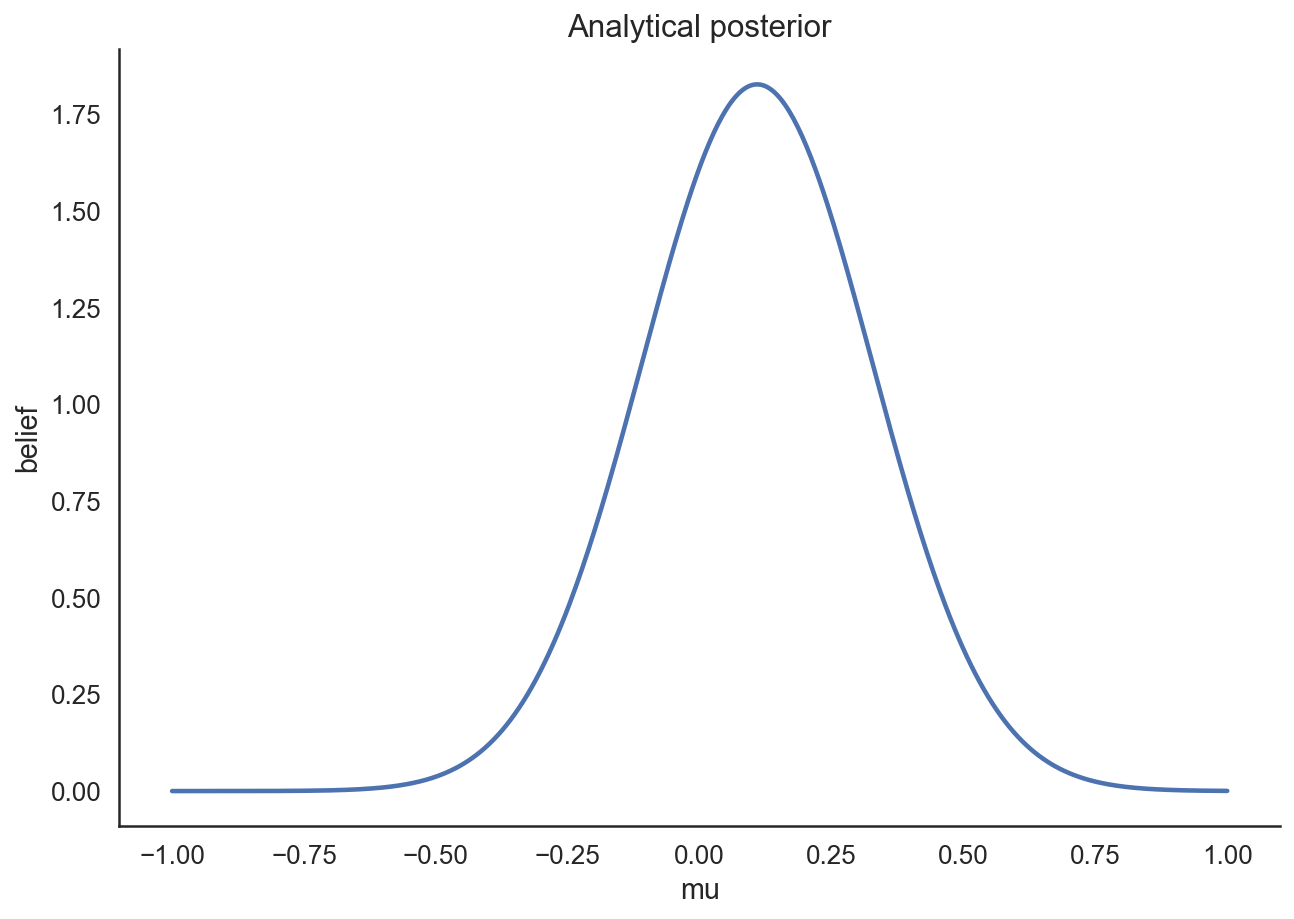

In [8]:
def calc_posterior_analytical(data, x, mu_0, sigma_0):
    sigma = 1.
    n = len(data)
    mu_post = (mu_0 / sigma_0**2 + data.sum() / sigma**2) / (1. / sigma_0**2 + n / sigma**2)
    sigma_post = (1. / sigma_0**2 + n / sigma**2)**-1
    return norm(mu_post, np.sqrt(sigma_post)).pdf(x)

ax = plt.subplot()
x = np.linspace(-1, 1, 500)
posterior_analytical = calc_posterior_analytical(data, x, 0., 1.)
ax.plot(x, posterior_analytical)
ax.set(xlabel='mu', ylabel='belief', title='Analytical posterior');
sns.despine()

This shows our quantity of interest, the probability of $\mu$'s values after having seen the data, taking our prior information into account. Lets assume, however, that our prior wasn't conjugate and we couldn't solve this by hand which is usually the case.

上图表示了我们感兴趣的量，根据先验信息和数据得到的$\mu$的概率分布。现在假设先验不是共轭的，也就是说我们无法手动将其算出来（实际中大多数时候都如此）。

## Explaining MCMC sampling with code

## 用代码解释MCMC采样

Now on to the sampling logic. At first, you find starting parameter position (can be randomly chosen), lets fix it arbitrarily to:

接下来是采样逻辑。首先，找到一个参数的起始点（可以随机选择），这里我们选一个固定值：

```python
mu_current = 1.
```

Then, you propose to move (jump) from that position somewhere else (that's the Markov part). You can be very dumb or very sophisticated about how you come up with that proposal. The Metropolis sampler is very dumb and just takes a sample from a normal distribution (no relationship to the normal we assume for the model) centered around your current `mu` value (i.e. `mu_current`) with a certain standard deviation (`proposal_width`) that will determine how far you propose jumps (here we're use `scipy.stats.norm`):

然后，你可以提出从上面那个位置跳到其它某个位置（这就是马尔科夫部分），至于跳到哪个位置，你可以选用很笨或者很高级的方法。Metropolis采样使用的是一个很笨的办法，选定一个正态分布，其均值为当前`mu`的值，标准差为`proposal_width`(该值决定了每次大概跳多远)，然后从该分布中随机采样一个值。

```python
proposal = norm(mu_current, proposal_width).rvs()
```

Next, you evaluate whether that's a good place to jump to or not. If the resulting normal distribution with that proposed `mu` explaines the data better than your old `mu`, you'll definitely want to go there. What does "explains the data better" mean? We quantify fit by computing the probability of the data, given the likelihood (normal) with the proposed parameter values (proposed `mu` and a fixed `sigma = 1`). This can easily be computed by calculating the probability for each data point using `scipy.stats.normal(mu, sigma).pdf(data)` and then multiplying the individual probabilities, i.e. compute the likelihood (usually you would use log probabilities but we omit this here):

接下来，评估是否应该跳到新提出的`proposal`，如果新的`propossal`要比原来的`mu`能够更好地解释数据，那么就跳到那里。什么叫“更好地解释数据”？我们可以比较二者的（正态）似然，通过`scipy.stats.normal(mu, sigma).pdf(data)` 得到每个点的生成概率然后相乘（通常你可能会使用log似然，不过这里我们暂时忽略这个）。

```python
likelihood_current = norm(mu_current, 1).pdf(data).prod()
likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()
        
# Compute prior probability of current and proposed mu        
prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)

# Nominator of Bayes formula
p_current = likelihood_current * prior_current
p_proposal = likelihood_proposal * prior_proposal

```

Up until now, we essentially have a hill-climbing algorithm that would just propose movements into random directions and only accept a jump if the `mu_proposal` has higher likelihood than `mu_current`. Eventually we'll get to `mu = 0` (or close to it) from where no more moves will be possible. However, we want to get a posterior so we'll also have to sometimes accept moves into the other direction. The key trick is by dividing the two probabilities,

目前为止，我们本质上有了一个爬坡算法，随机朝某个方向找到一个点，只在`mu_proposal`比`mu_current`的似然更高的时候跳过去。不过，我们希望得到的是后验分布，因此我们希望有时候也能接受朝其它方向的跳转，其核心在于将两个概率相除。

```python
p_accept = p_proposal / p_current
```

we get an acceptance probability. You can already see that if `p_proposal` is larger, that probability will be `> 1` and we'll definitely accept. However, if `p_current` is larger, say twice as large, there'll be a 50% chance of moving there:

上面算出了一个接受概率，可以看到，如果`p_proposal` 更大，那么得到的概率会`> 1`，因而我们一定会接受新的位置，不过，如果`p_current`更大，比如说两倍大，那么我们有50%的概率移动到新的位置。

```python
accept = np.random.rand() < p_accept

if accept:
    # Update position
    cur_pos = proposal

```

This simple procedure gives us samples from the posterior.

该过程为我们提供了后验分布的采样。

### Why does this make sense?

### 为什么这么做行得通？

Taking a step back, note that the above acceptance ratio is the reason this whole thing works out and we get around the integration. We can show this by computing the acceptance ratio over the normalized posterior and seeing how it's equivalent to the acceptance ratio of the unnormalized posterior (lets say $\mu_0$ is our current position, and $\mu$ is our proposal):

往后退一步，整个采样过程最核心的是接受率。可以通过计算归一化之后的后验分布来证明这点，从而可以看出它与没有归一化的后验分布的接受率是相同的（这里用$\mu_0$表示当前位置，$\mu$表示我们提出的新位置）。

$$ \frac{\frac{P(x|\mu) P(\mu)}{P(x)}}{\frac{P(x|\mu_0) P(\mu_0)}{P(x)}} = \frac{P(x|\mu) P(\mu)}{P(x|\mu_0) P(\mu_0)}$$

In words, dividing the posterior of proposed parameter setting by the posterior of the current parameter setting, $P(x)$ -- that nasty quantity we can't compute -- gets canceled out. So you can intuit that we're actually dividing the full posterior at one position by the full posterior at another position (no magic here). That way, we are visiting regions of high posterior probability *relatively* more often than those of low posterior probability.

换句话说，两个似然相除的时候，将我们不好计算的$P(x)$部分消掉了。直观上讲，我们对于后验概率较高的地方*相对*后验概率较低的地方，访问得更频繁一些。

### Putting it all together

### 将这些全都组织起来

In [9]:
def sampler(data, samples=4, mu_init=.5, proposal_width=.5, plot=False, mu_prior_mu=0, mu_prior_sd=1.):
    mu_current = mu_init
    posterior = [mu_current]
    for i in range(samples):
        # suggest new position
        mu_proposal = norm(mu_current, proposal_width).rvs()

        # Compute likelihood by multiplying probabilities of each data point
        likelihood_current = norm(mu_current, 1).pdf(data).prod()
        likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()
        
        # Compute prior probability of current and proposed mu        
        prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
        prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)
        
        p_current = likelihood_current * prior_current
        p_proposal = likelihood_proposal * prior_proposal
        
        # Accept proposal?
        p_accept = p_proposal / p_current
        
        # Usually would include prior probability, which we neglect here for simplicity
        accept = np.random.rand() < p_accept
        
        if plot:
            plot_proposal(mu_current, mu_proposal, mu_prior_mu, mu_prior_sd, data, accept, posterior, i)
        
        if accept:
            # Update position
            mu_current = mu_proposal
        
        posterior.append(mu_current)
        
    return posterior

# Function to display
def plot_proposal(mu_current, mu_proposal, mu_prior_mu, mu_prior_sd, data, accepted, trace, i):
    from copy import copy
    trace = copy(trace)
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(16, 4))
    fig.suptitle('Iteration %i' % (i + 1))
    x = np.linspace(-3, 3, 5000)
    color = 'g' if accepted else 'r'
        
    # Plot prior
    prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
    prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)
    prior = norm(mu_prior_mu, mu_prior_sd).pdf(x)
    ax1.plot(x, prior)
    ax1.plot([mu_current] * 2, [0, prior_current], marker='o', color='b')
    ax1.plot([mu_proposal] * 2, [0, prior_proposal], marker='o', color=color)
    ax1.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    ax1.set(ylabel='Probability Density', title='current: prior(mu=%.2f) = %.2f\nproposal: prior(mu=%.2f) = %.2f' % (mu_current, prior_current, mu_proposal, prior_proposal))
    
    # Likelihood
    likelihood_current = norm(mu_current, 1).pdf(data).prod()
    likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()
    y = norm(loc=mu_proposal, scale=1).pdf(x)
    sns.distplot(data, kde=False, norm_hist=True, ax=ax2)
    ax2.plot(x, y, color=color)
    ax2.axvline(mu_current, color='b', linestyle='--', label='mu_current')
    ax2.axvline(mu_proposal, color=color, linestyle='--', label='mu_proposal')
    #ax2.title('Proposal {}'.format('accepted' if accepted else 'rejected'))
    ax2.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    ax2.set(title='likelihood(mu=%.2f) = %.2f\nlikelihood(mu=%.2f) = %.2f' % (mu_current, 1e14*likelihood_current, mu_proposal, 1e14*likelihood_proposal))
    
    # Posterior
    posterior_analytical = calc_posterior_analytical(data, x, mu_prior_mu, mu_prior_sd)
    ax3.plot(x, posterior_analytical)
    posterior_current = calc_posterior_analytical(data, mu_current, mu_prior_mu, mu_prior_sd)
    posterior_proposal = calc_posterior_analytical(data, mu_proposal, mu_prior_mu, mu_prior_sd)
    ax3.plot([mu_current] * 2, [0, posterior_current], marker='o', color='b')
    ax3.plot([mu_proposal] * 2, [0, posterior_proposal], marker='o', color=color)
    ax3.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    #x3.set(title=r'prior x likelihood $\propto$ posterior')
    ax3.set(title='posterior(mu=%.2f) = %.5f\nposterior(mu=%.2f) = %.5f' % (mu_current, posterior_current, mu_proposal, posterior_proposal))
    
    if accepted:
        trace.append(mu_proposal)
    else:
        trace.append(mu_current)
    ax4.plot(trace)
    ax4.set(xlabel='iteration', ylabel='mu', title='trace')
    plt.tight_layout()
    #plt.legend()

## Visualizing MCMC

## MCMC过程可视化

To visualize the sampling, we'll create plots for some quantities that are computed. Each row below is a single iteration through our Metropolis sampler. 

为了将采样过程可视化地表示出来，我们计算得到的一些量画了出来，下面每一行表示Metropolis采样的每一步迭代过程。

The first columns is our prior distribution -- what our belief about $\mu$ is before seeing the data. You can see how the distribution is static and we only plug in our $\mu$ proposals. The vertical lines represent our current $\mu$ in blue and our proposed $\mu$ in either red or green (rejected or accepted, respectively). 

第一列是先验分布——即在看到数据之前我们关于$\mu$的理解。可以看到该分布是静态的，我们只是在其中画出了每次提出跳转的$\mu$。

The 2nd column is our likelihood and what we are using to evaluate how good our model explains the data. You can see that the likelihood function changes in response to the proposed $\mu$. The blue histogram which is our data. The solid line in green or red is the likelihood with the currently proposed `mu`. Intuitively, the more overlap there is between likelihood and data, the better the model explains the data and the higher the resulting probability will be. The dotted line of the same color is the proposed `mu` and the dotted blue line is the current `mu`.

第二列是似然，用来衡量模型对数据的解释能力。可以看到似然函数随着$\mu$的变化而变化，蓝色的直方图表示数据，绿色或者红色的线表示当前位置提出的`mu`。直观上看，似然与数据的重叠度越大，模型对数据的解释能力越好，从而得到的概率也就越高。其中红色或绿色的虚线表示相应的提出的`mu`，蓝色的虚线表示当前的`mu`。

The 3rd column is our posterior distribution. Here I am displaying the normalized posterior but as we found out above, we can just multiply the prior value for the current and proposed $\mu$'s by the likelihood value for the two $\mu$'s to get the unnormalized posterior values (which we use for the actual computation), and divide one by the other to get our acceptance probability.

第三列是后验分布，这里我直接画出了正态分布的后验，不过从前面可以看出，我们可以直接当前$\mu$和提出的$\mu$的先验，乘上似然，得到没有归一化的后验，然后将两个后验相除就得到了接受率。

The 4th column is our trace (i.e. the posterior samples of $\mu$ we're generating) where we store each sample irrespective of whether it was accepted or rejected (in which case the line just stays constant).

第四列表示的是*迹*（从后验中生成的采样），这里保存了所有的采样，不论采样值是否被接受（如果采样值被拒绝的话，就保留上一个采样值，从图中看起来就是一条水平的线）。[译者注：这点很关键！]

Note that we always move to relatively more likely $\mu$ values (in terms of their posterior density), but only sometimes to relatively less likely $\mu$ values, as can be seen in iteration 14 (the iteration number can be found at the top center of each row).

留意这里总是会跳到与$\mu$值相似的地方（这里的相似是指后验密度相似），不过偶尔也会跳到不怎么相似的地方，可以从第14轮迭代中看出这点。（需要修改下面的代码中`samples`的值）

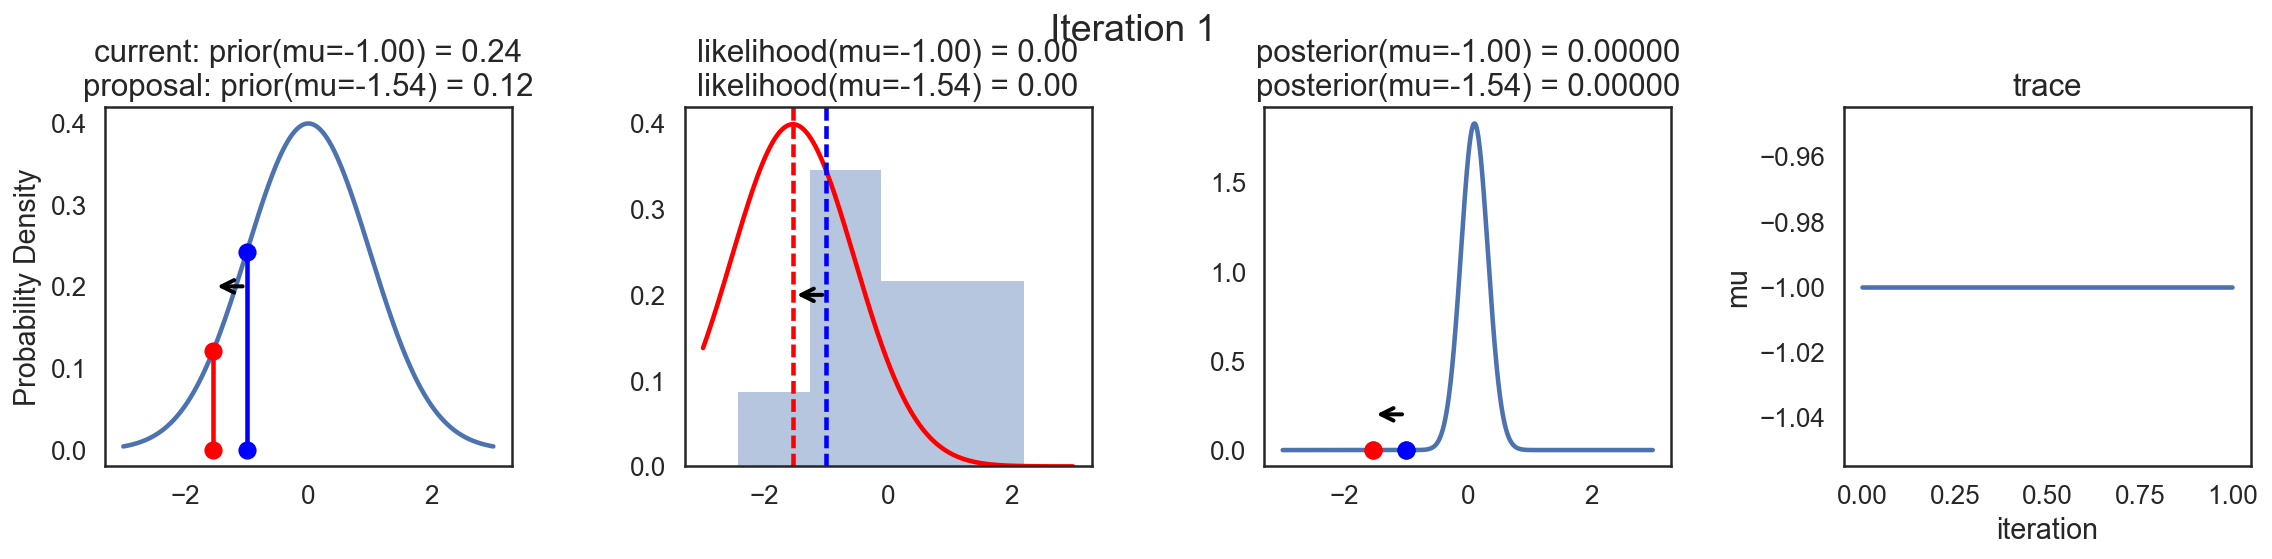

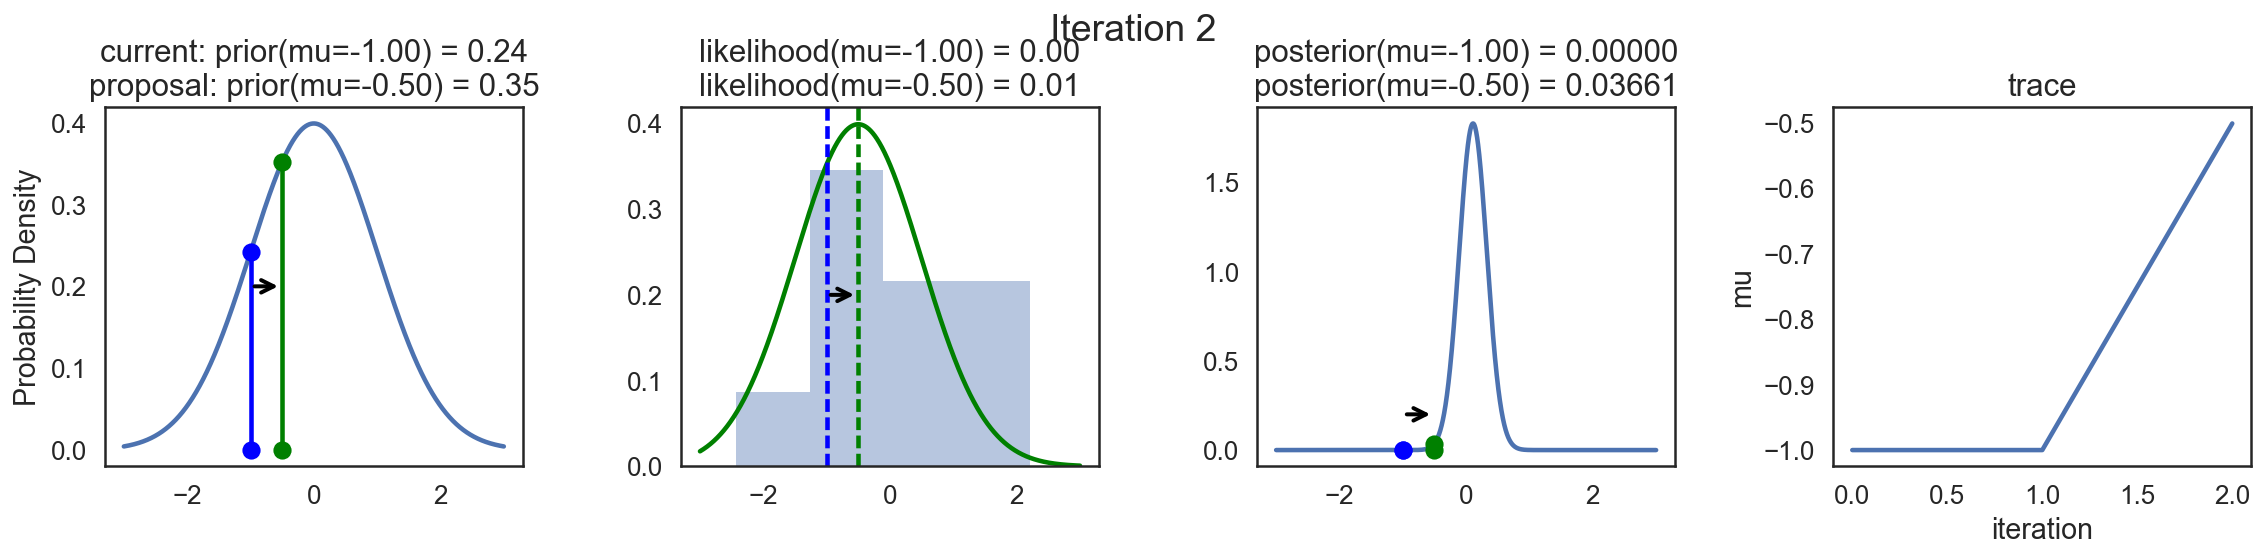

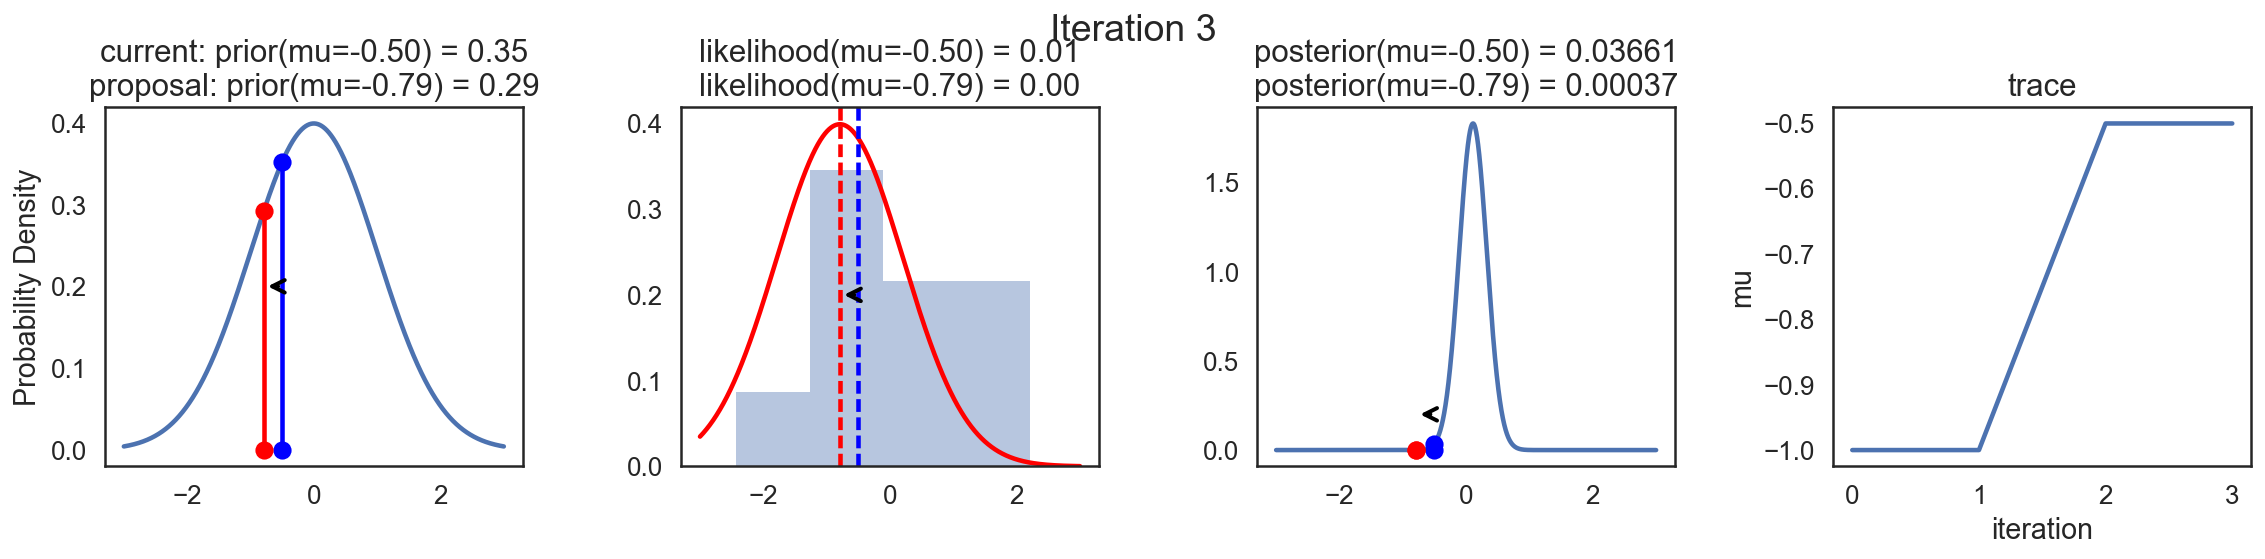

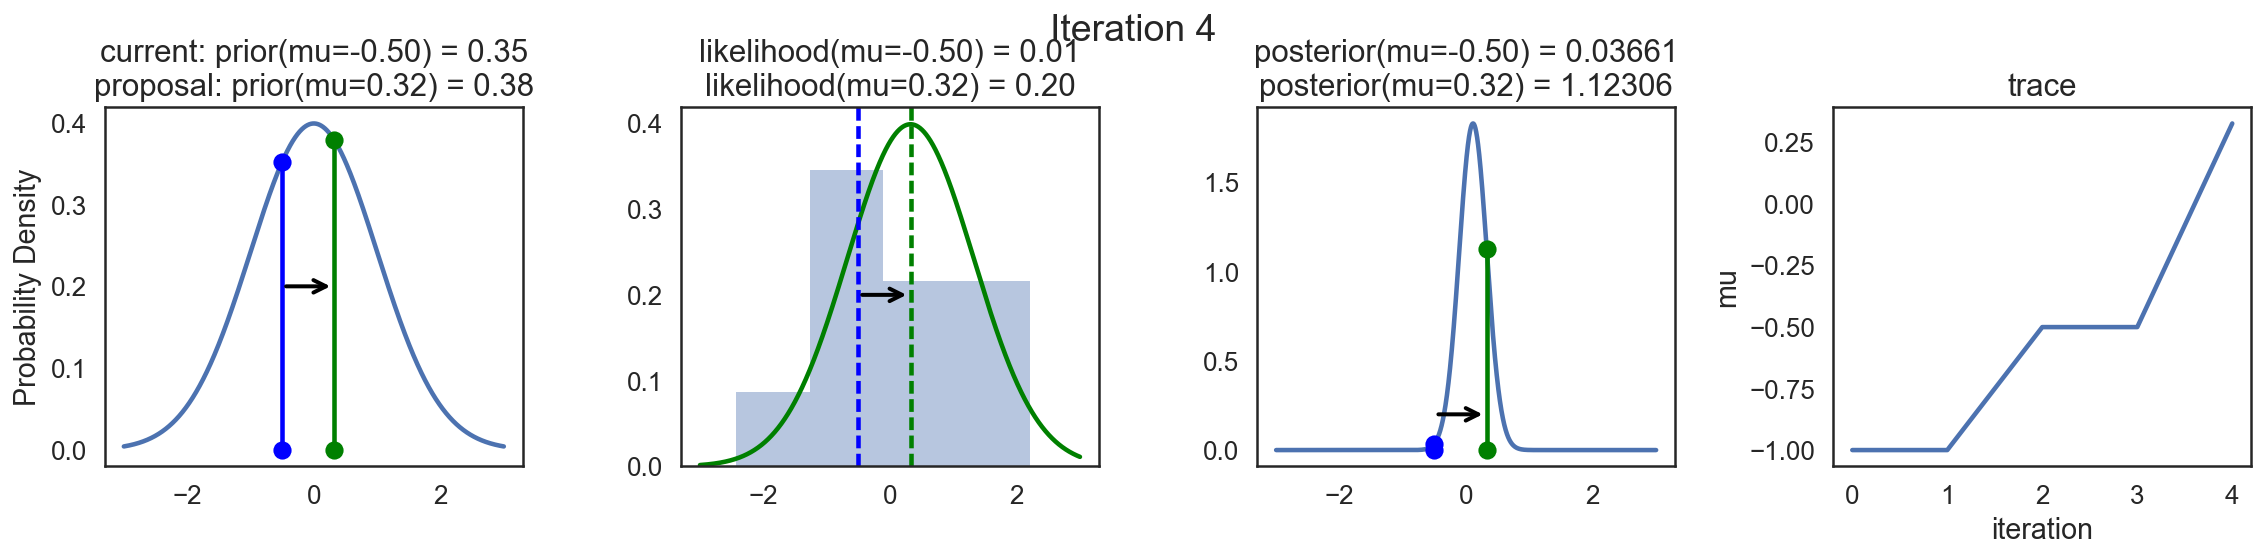

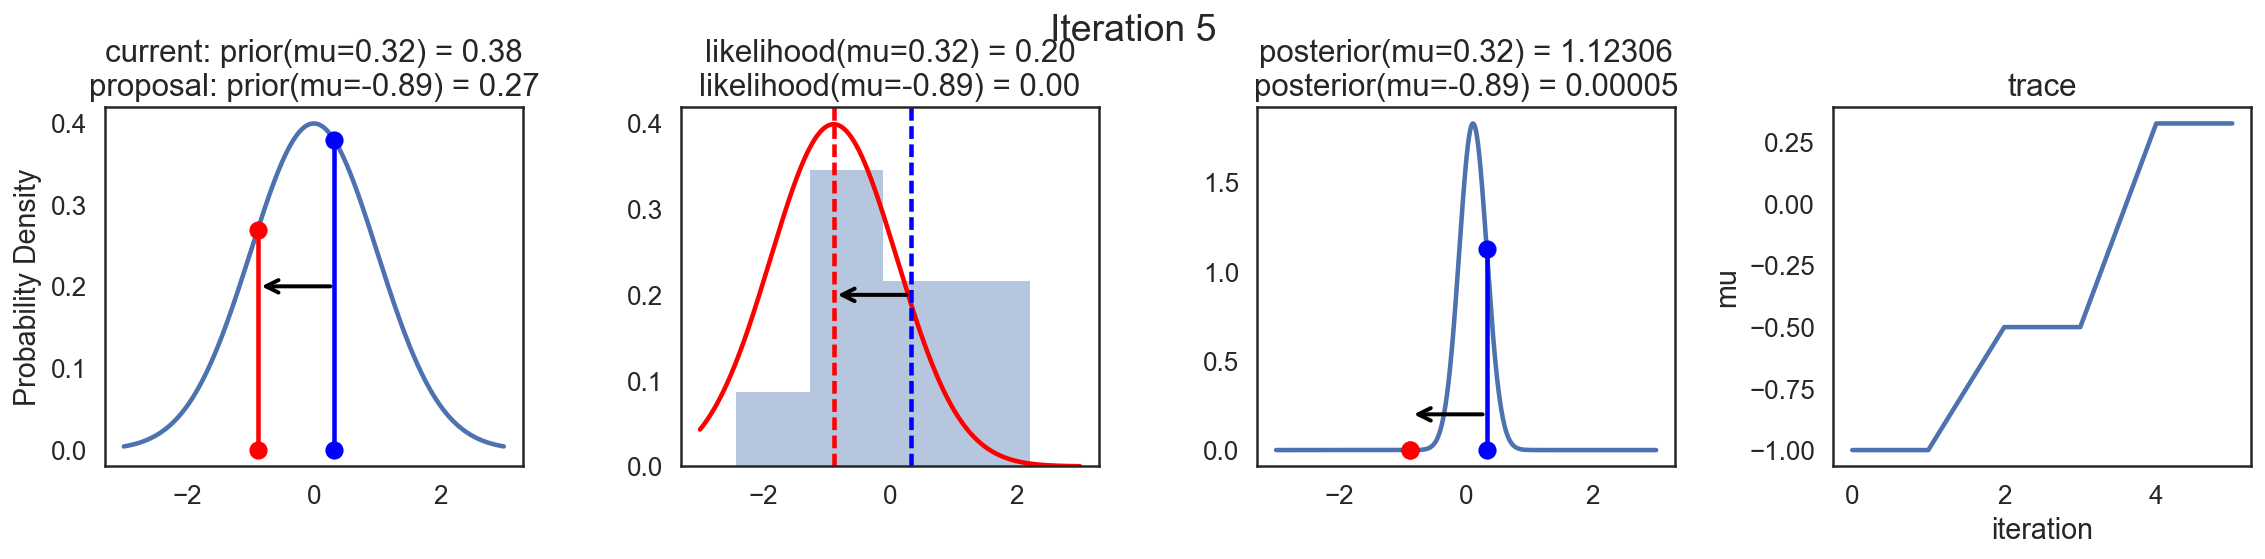

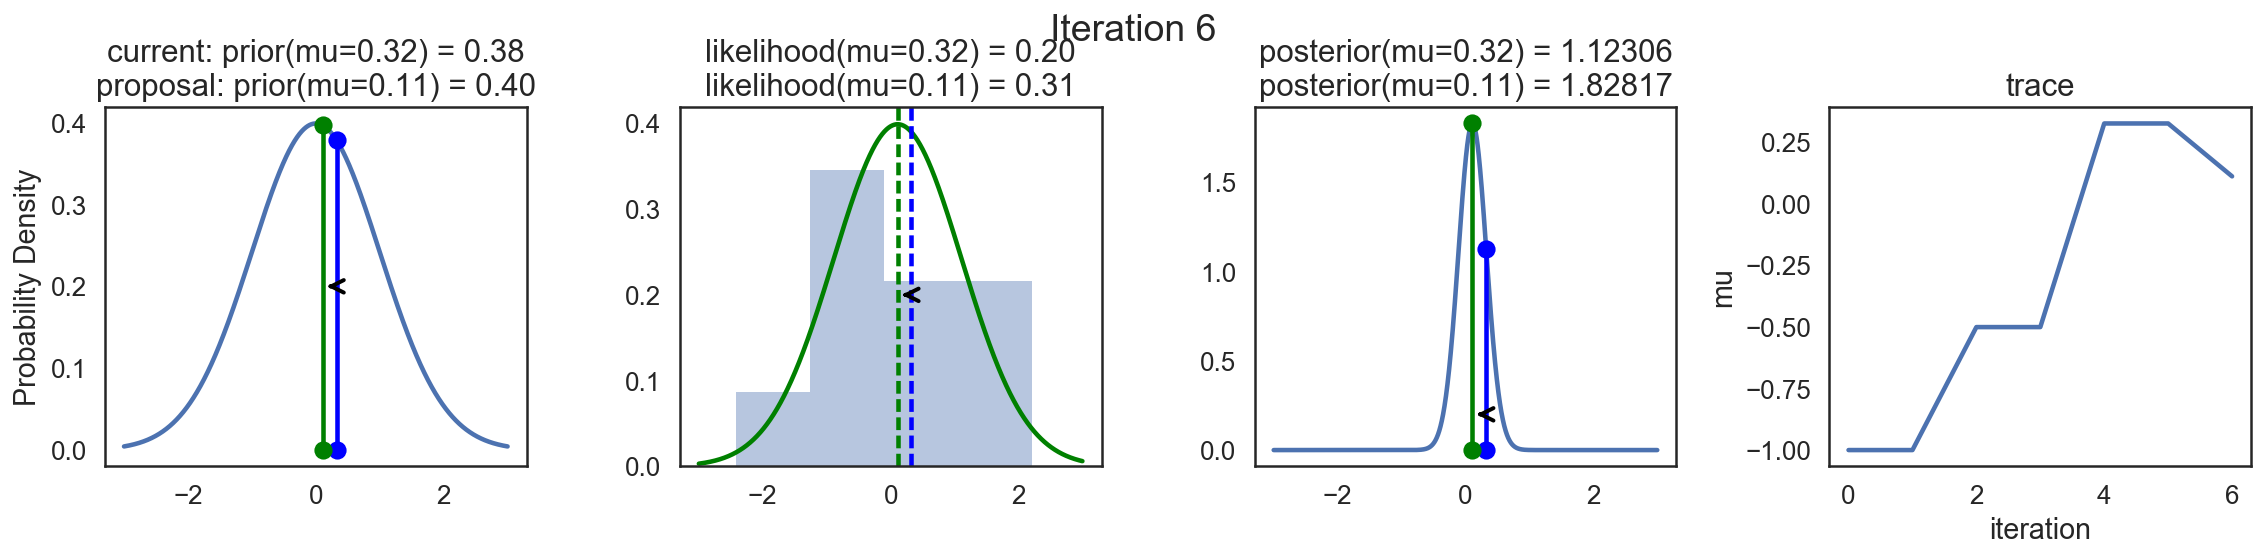

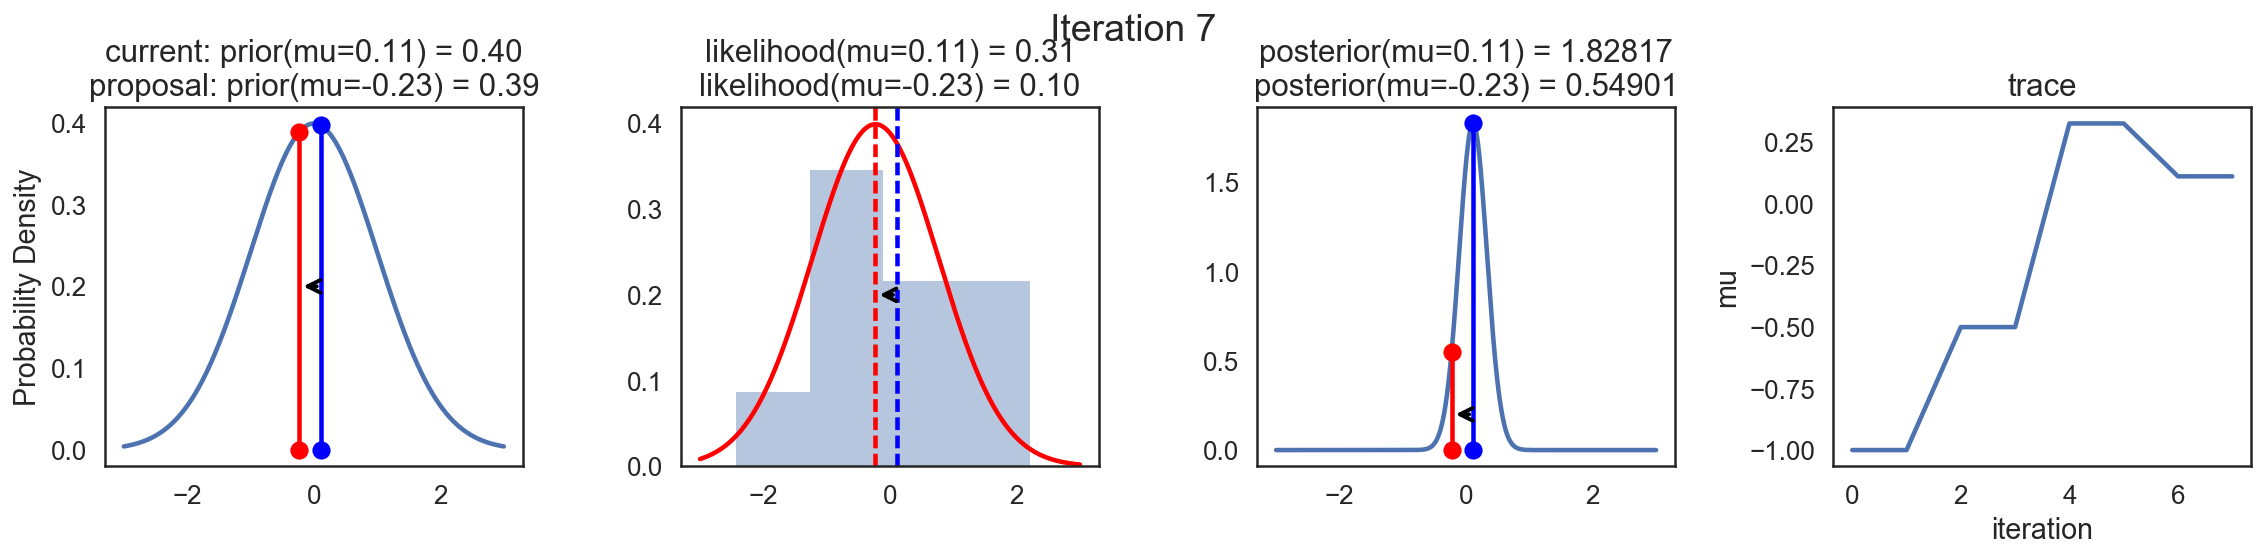

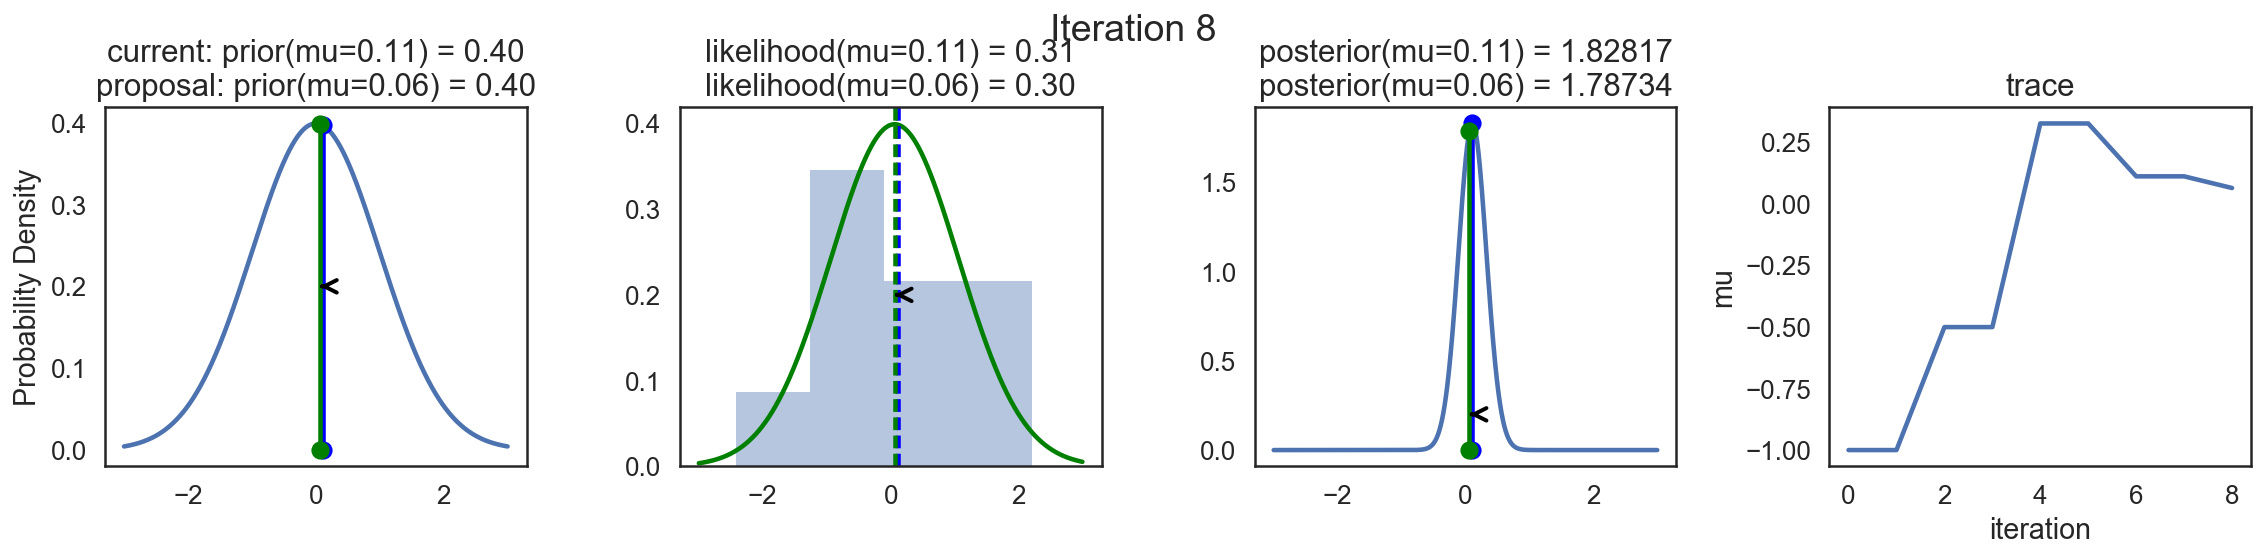

In [12]:
np.random.seed(123)
sampler(data, samples=8, mu_init=-1., plot=True);

Now the magic of MCMC is that you just have to do that for a long time, and the samples that are generated in this way come from the posterior distribution of your model. There is a rigorous mathematical proof that guarantees this which I won't go into detail here.

MCMC方法的神奇之处在于，你只需要采样足够多次就可以了，有数学证明可以保证最终的分布与真实的后验分布是一致的。（这里暂不深入其中的数学细节）

To get a sense of what this produces, lets draw a lot of samples and plot them.

下面多画一些采样值感受下：

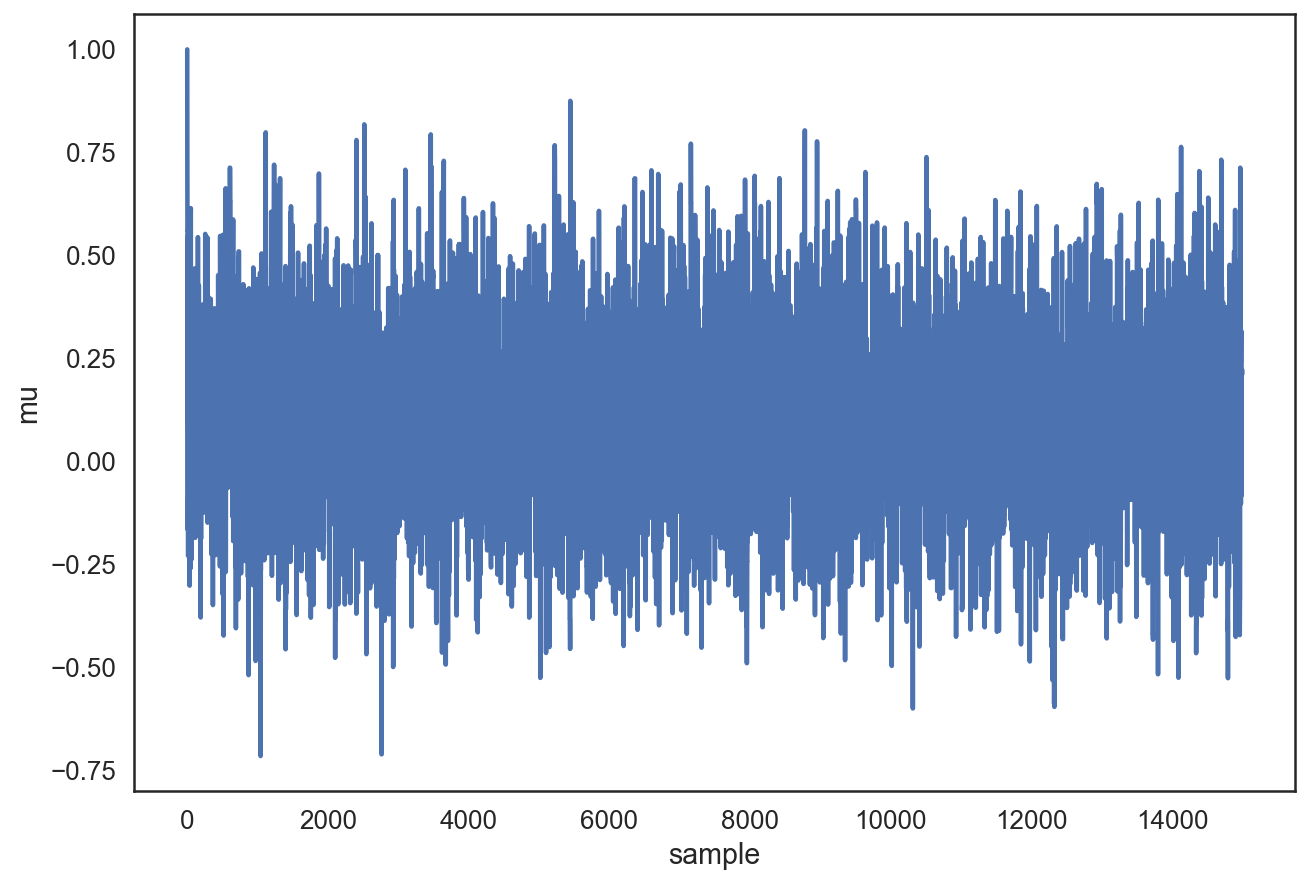

In [13]:
posterior = sampler(data, samples=15000, mu_init=1.)
fig, ax = plt.subplots()
ax.plot(posterior)
_ = ax.set(xlabel='sample', ylabel='mu');

This is usually called the trace. To now get an approxmation of the posterior (the reason why we're doing all this), we simply take the histogram of this trace. It's important to keep in mind that although this looks similar to the data we sampled above to fit the model, the two are completely separate. The below plot represents our **belief** in `mu`. In this case it just happens to also be normal but for a different model, it could have a completely different shape than the likelihood or prior.

上图一般称作**迹**，现在为了得到后验的近似（本文讨论的核心），只需要简单地将迹的直方图画出来即可。要牢记，尽管这看起来跟前面的采样很像，单着是完全不同的两码事。下图表示的是我们对`mu`的**信念**，它只是恰好看起来是正态的，不过完全可以与先验和似然的分布形状不同。[译者注：这里作者是想强调MCMC方法与共轭分析的方法之间的区别]

/Users/didi/anaconda2/envs/py3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


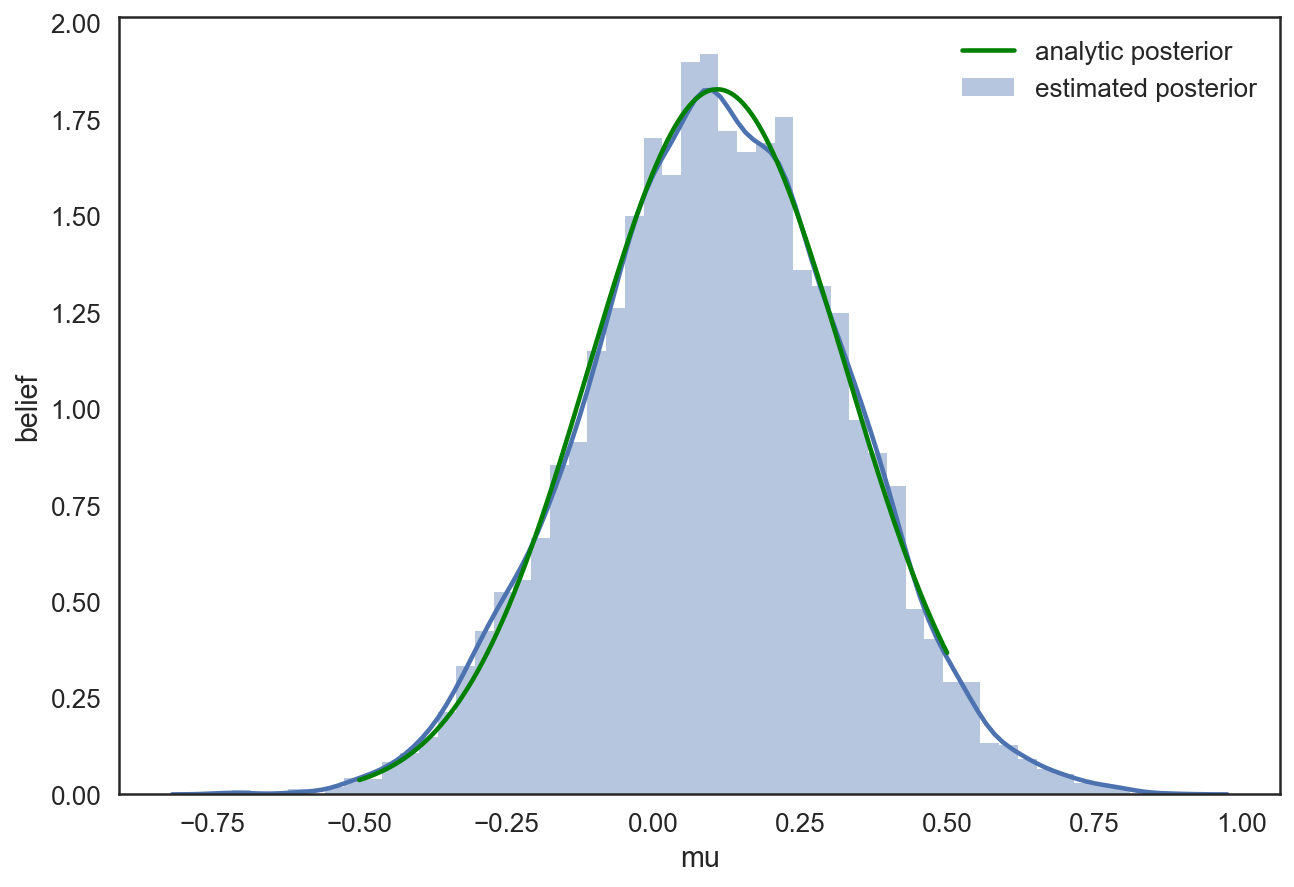

In [14]:
ax = plt.subplot()

sns.distplot(posterior[500:], ax=ax, label='estimated posterior')
x = np.linspace(-.5, .5, 500)
post = calc_posterior_analytical(data, x, 0, 1)
ax.plot(x, post, 'g', label='analytic posterior')
_ = ax.set(xlabel='mu', ylabel='belief');
ax.legend();

As you can see, by following the above procedure, we get samples from the same distribution as what we derived analytically.

可以看到，根据上面的过程得到的分布与前面分析得到的分布非常接近。

## Proposal width

## 步长

Above we set the proposal width to `0.5`. That turned out to be a pretty good value. In general you don't want the width to be too narrow because your sampling will be inefficient as it takes a long time to explore the whole parameter space and shows the typical random-walk behavior:

前面将每次跳转的方差设为了`0.5`，这恰好是个不错的值，通常我们不会将该值设得比较小，因为这样采样的话很低效，需要走很多步才能探索完整个参数空间，而且会表现出一些随机游走的现象：

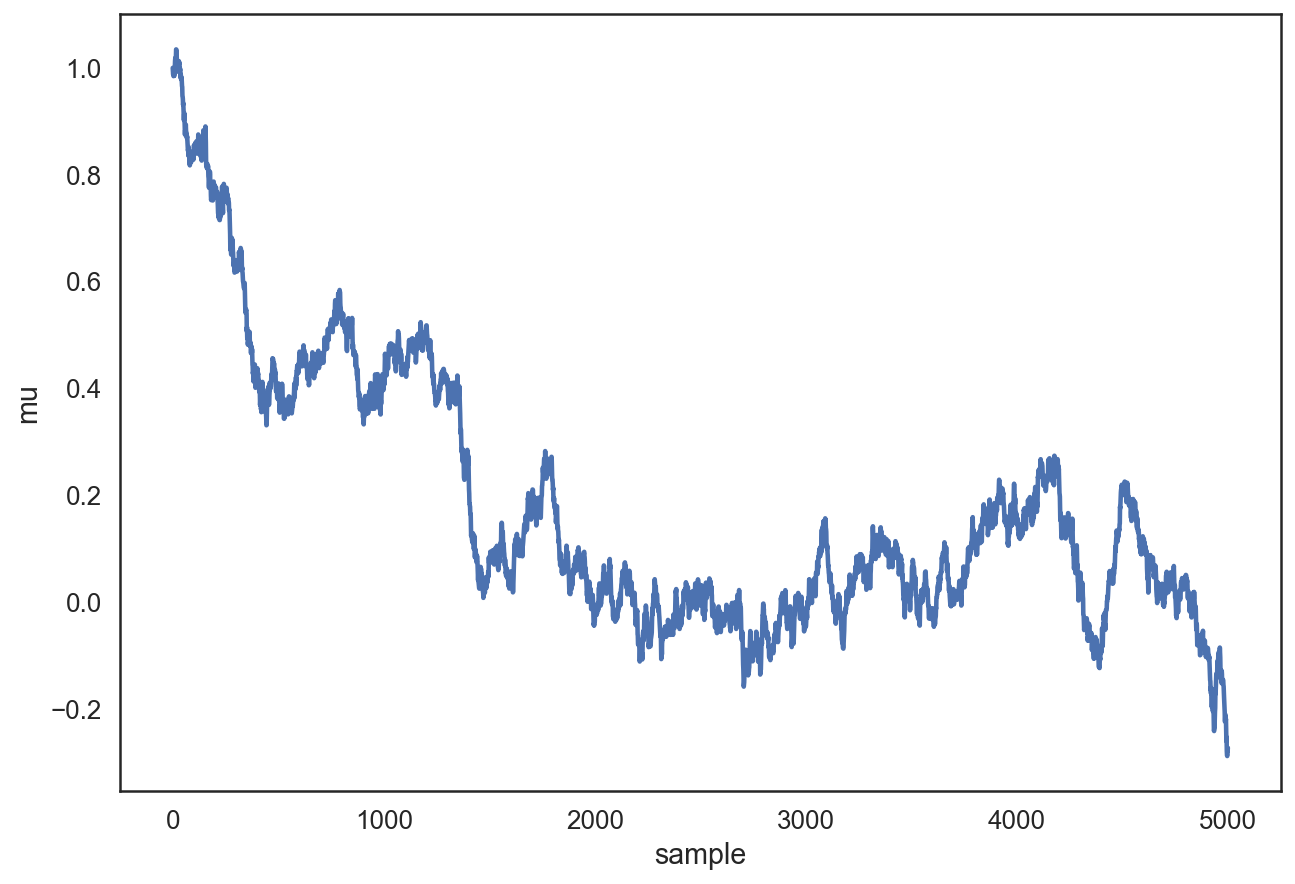

In [15]:
posterior_small = sampler(data, samples=5000, mu_init=1., proposal_width=.01)
fig, ax = plt.subplots()
ax.plot(posterior_small);
_ = ax.set(xlabel='sample', ylabel='mu');

But you also don't want it to be so large that you never accept a jump:

不过也不能把步长设得太大，这样会很难接受某次跳转。

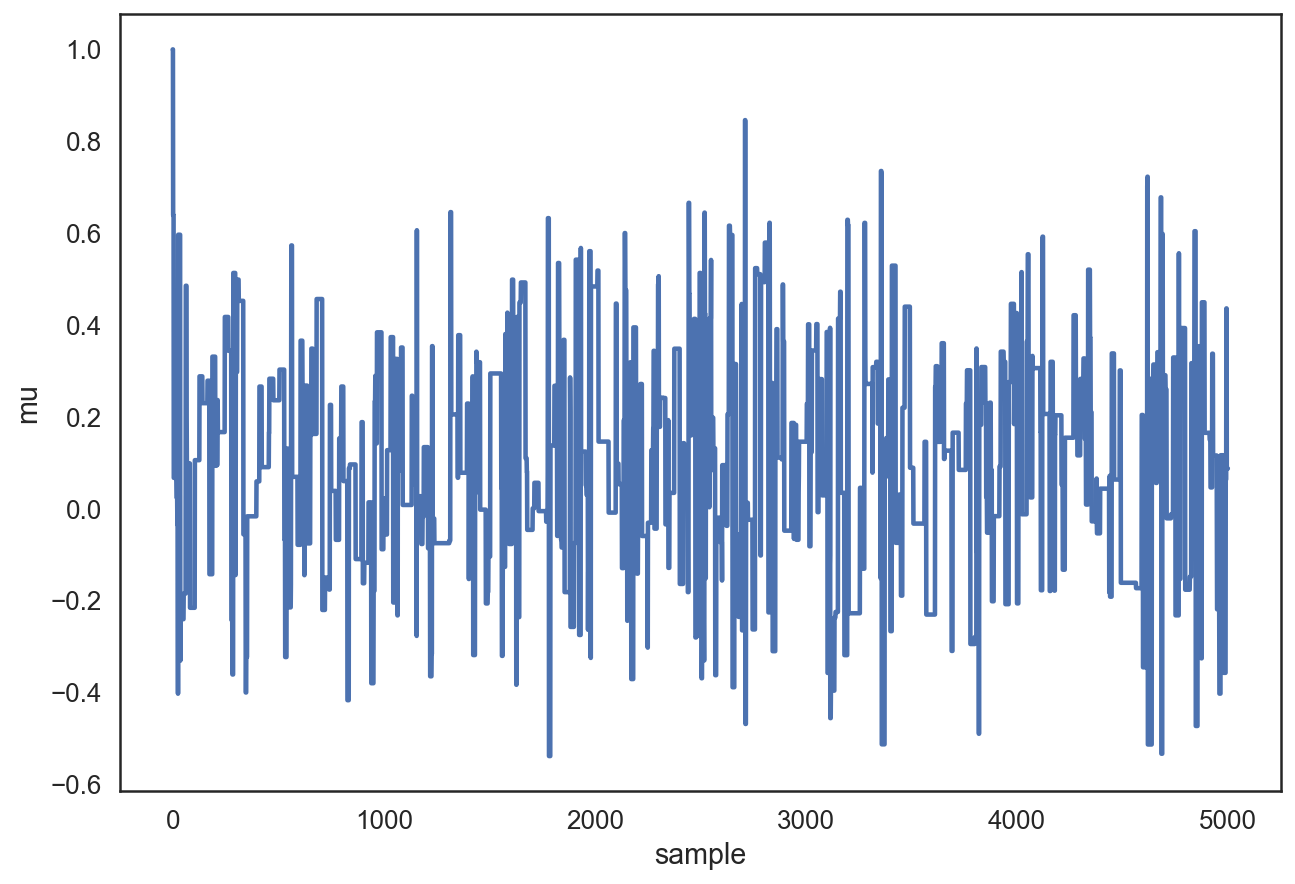

In [16]:
posterior_large = sampler(data, samples=5000, mu_init=1., proposal_width=3.)
fig, ax = plt.subplots()
ax.plot(posterior_large); plt.xlabel('sample'); plt.ylabel('mu');
_ = ax.set(xlabel='sample', ylabel='mu');

Note, however, that we are still sampling from our target posterior distribution here as guaranteed by the mathemtical proof, just less efficiently:

需要注意的是，我们仍然是在从后验分布中采样，最后的收敛性有数学保证，只是效率有点低。

/Users/didi/anaconda2/envs/py3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


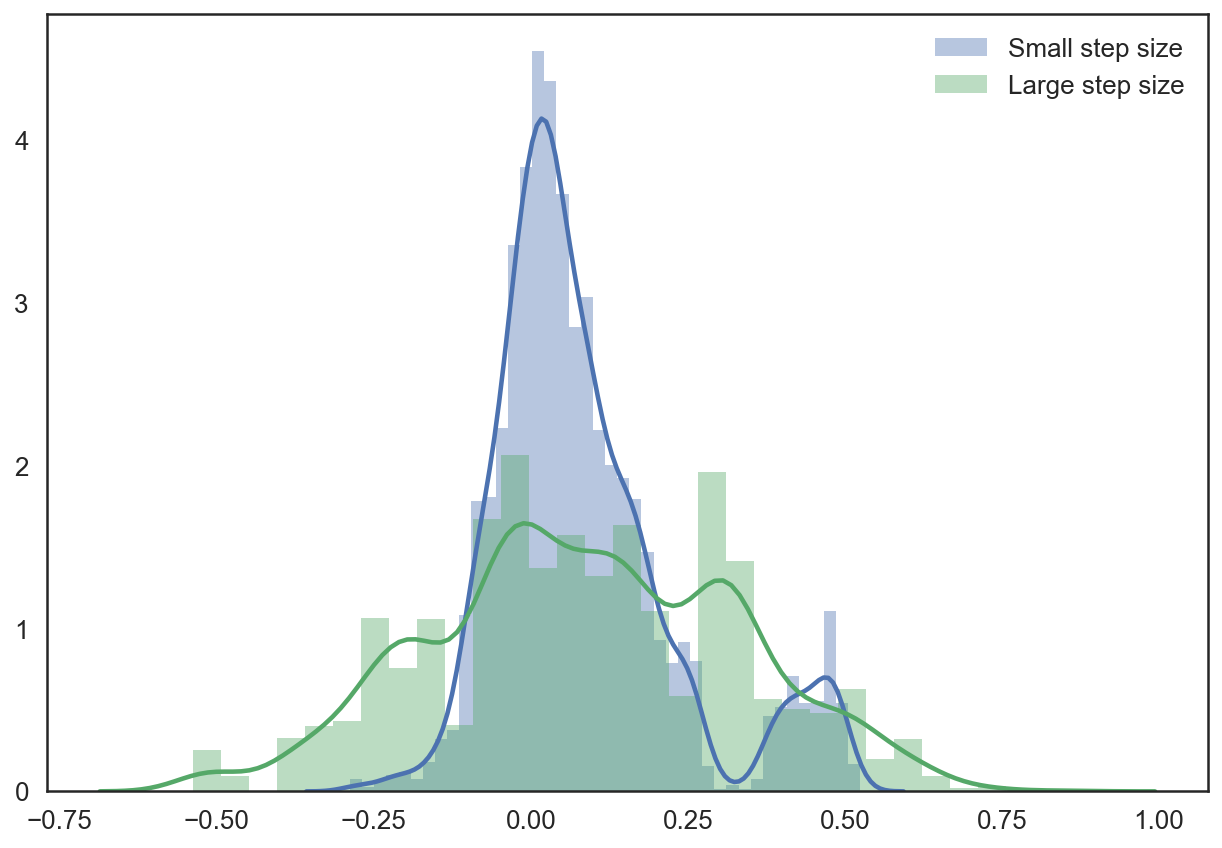

In [17]:
sns.distplot(posterior_small[1000:], label='Small step size')
sns.distplot(posterior_large[1000:], label='Large step size');
_ = plt.legend();

With more samples this will eventually look like the true posterior. The key is that we want our samples to be independent of each other which cleary isn't the case here. Thus, one common metric to evaluate the efficiency of our sampler is the autocorrelation -- i.e. how correlated a sample `i` is to sample `i-1`, `i-2`, etc:

只要采样次数足够，最终都会和真实的后验分布很像，这里关键在于我们希望采样之间是相互独立的，这里显然不是这样的。因此一个常见的衡量采样效率的标准是自相关性，即第`i`次采样与`i-1`和`i-2`次采样之间的自相关性。

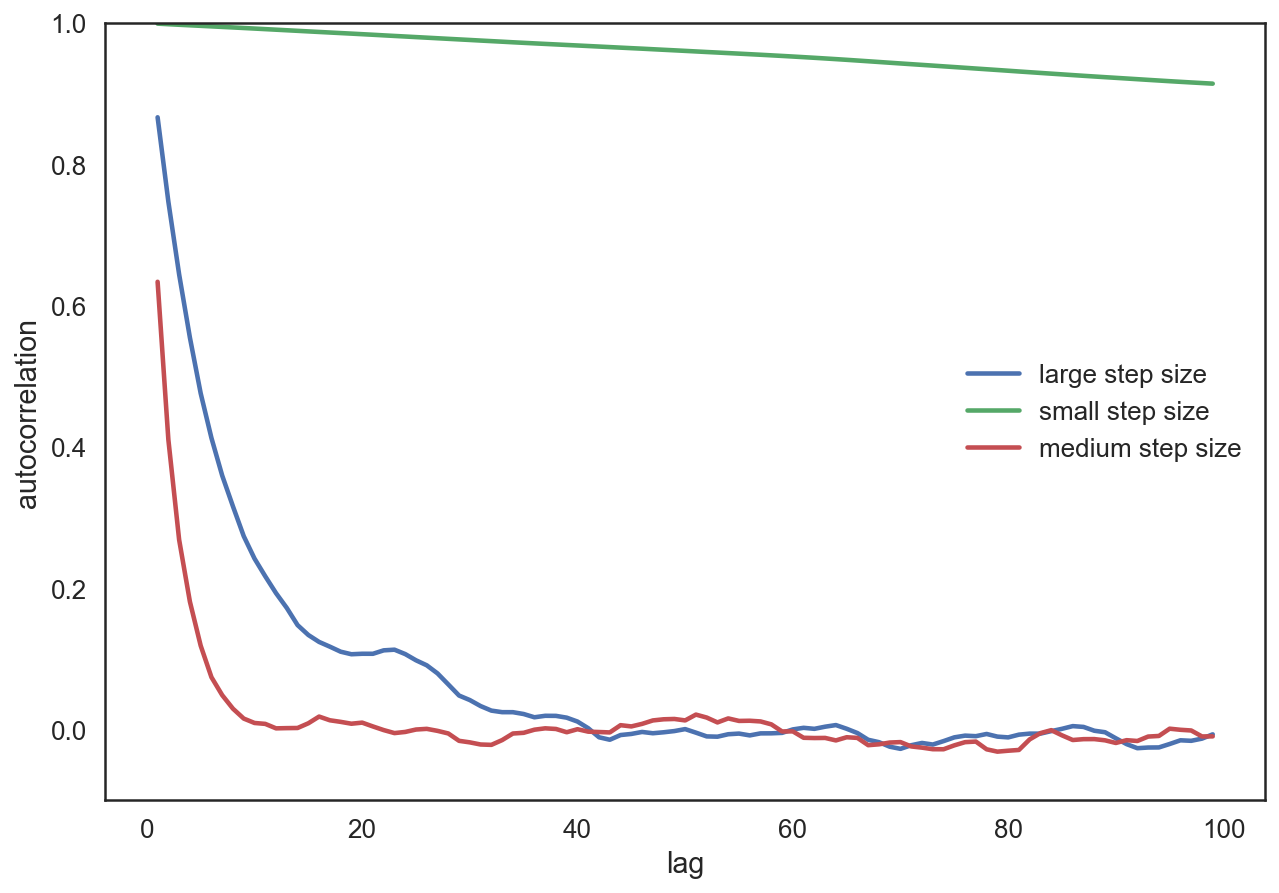

In [18]:
from pymc3.stats import autocorr
lags = np.arange(1, 100)
fig, ax = plt.subplots()
ax.plot(lags, [autocorr(posterior_large, l) for l in lags], label='large step size')
ax.plot(lags, [autocorr(posterior_small, l) for l in lags], label='small step size')
ax.plot(lags, [autocorr(posterior, l) for l in lags], label='medium step size')
ax.legend(loc=0)
_ = ax.set(xlabel='lag', ylabel='autocorrelation', ylim=(-.1, 1))

Obviously we want to have a smart way of figuring out the right step width automatically. One common method is to keep adjusting the proposal width so that roughly 50% proposals are rejected.

显然，我们希望有一种更聪明的办法自动找到合适的步长，一个常见的办法是尽量调整步长使得大约50%的跳转被拒绝。

## Extending to more complex models

## 扩展到更复杂的模型

Now you can easily imagine that we could also add a `sigma` parameter for the standard-deviation and follow the same procedure for this second parameter. In that case, we would be generating proposals for `mu` *and* `sigma` but the algorithm logic would be nearly identical. Or, we could have data from a very different distribution like a Binomial and still use the same algorithm and get the correct posterior. That's pretty cool and a huge benefit of probabilistic programming: Just define the model you want and let MCMC take care of the inference.

现在我们将标准差也设为参数（记为`sigma`），这样我们就有`mu`和`sigma`两个参数要跳转了，不过跳转的算法逻辑是一致的。或者，数据可以换成是从二项分布中得到的，继续使用同样的算法，仍然可以得到正确的后验。这正是概率编程的优势所在：你只需要定义好模型，剩下的让MCMC推断就好了。

For example, the below model can be written in `PyMC3` quite easily. Below we also use the Metropolis sampler (which automatically tunes the proposal width) and see that we get identical results. Feel free to play around with this and change the distributions. For more information, as well as more complex examples, see the [PyMC3 documentation](http://pymc-devs.github.io/pymc3/getting_started/).

比如，下面的模型可以用`PyMC3`很简单地写出来，下面的代码用的是Metropolis采样（会自动调整步长），你可以自己随意更换下分布看看。更多的例子可以参考[PyMC3文档](http://pymc-devs.github.io/pymc3/getting_started/)。

100%|██████████| 15500/15500 [00:01<00:00, 11142.94it/s]
/Users/didi/anaconda2/envs/py3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


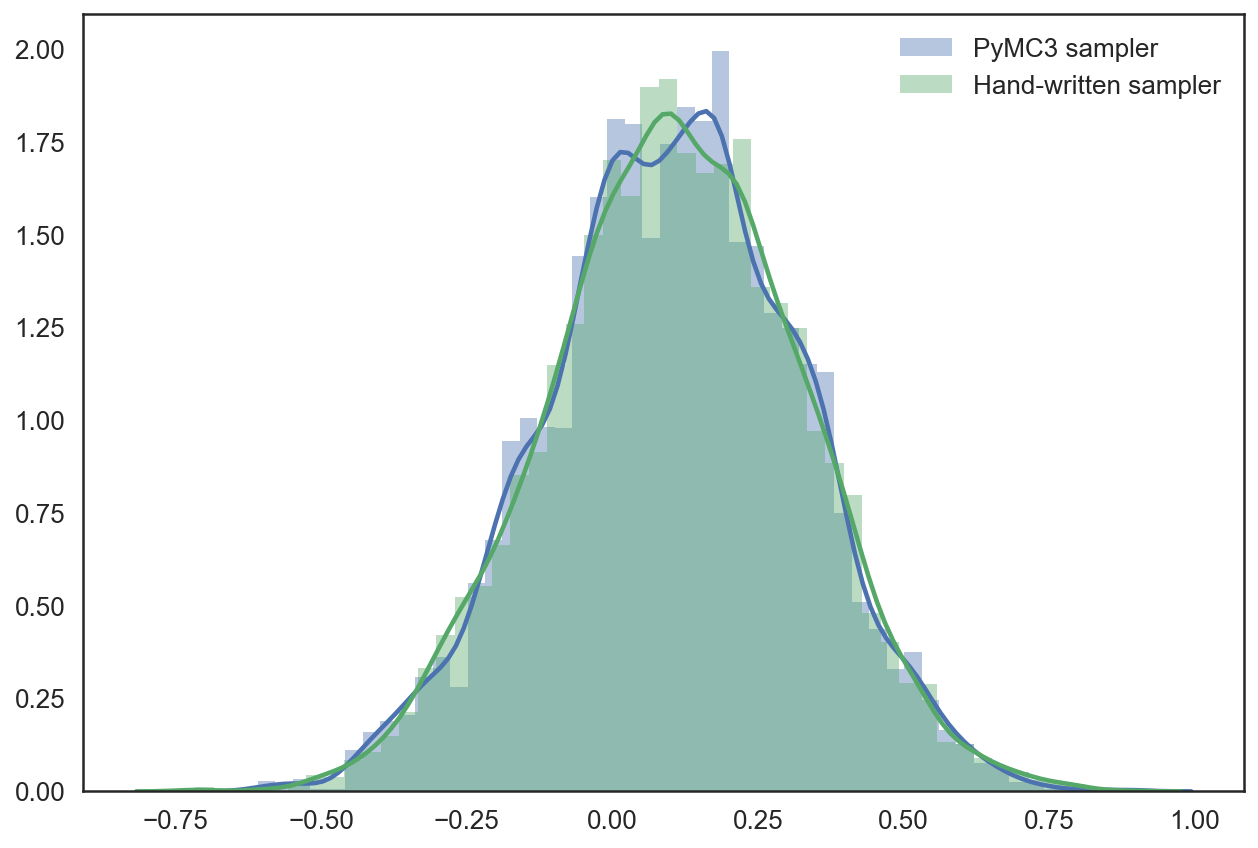

In [19]:
import pymc3 as pm

with pm.Model():
    mu = pm.Normal('mu', 0, 1)
    sigma = 1.
    returns = pm.Normal('returns', mu=mu, sd=sigma, observed=data)
    
    step = pm.Metropolis()
    trace = pm.sample(15000, step)
    
sns.distplot(trace[2000:]['mu'], label='PyMC3 sampler');
sns.distplot(posterior[500:], label='Hand-written sampler');
plt.legend();

## Conclusions

## 总结

We glossed over a lot of detail which is certainly important but there are many other posts that deal with that. Here, we really wanted to communicate the idea of MCMC and the Metropolis sampler. Hopefully you will have gathered some intuition which will equip you to read one of the more technical introductions to this topic.

本文跳过了许多细节，这部分当然很重要，不过已经有许多文章讨论过了。这里我希望交流的是MCMC以及Metropolis采样的思想，但愿能帮助你建立一些直观感受，从而有助于你理解这个主题下的更多技术细节。

Other, more fancy, MCMC algorithms like Hamiltonian Monte Carlo actually work very similar to this, they are just much more clever in proposing where to jump next.

此外，还有许多类似的MCMC算法（如Hamiltonian Monte Carlo汉密尔顿-蒙特卡洛），它们在如何选择下一个跳转点方面更聪明一些~

This blog post was written in a Jupyter Notebook, you can find the underlying NB with all its code [here](https://github.com/twiecki/WhileMyMCMCGentlySamples/blob/master/content/downloads/notebooks/MCMC-sampling-for-dummies.ipynb).